<a href="https://colab.research.google.com/github/Fritz302/data-science/blob/main/FritKokiU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main Idea**

Lebron James is considered the GOAT of basketball by many, but how good is he really, and is he getting worse in his old age? In this project, I will be analyzing Lebron's Game Score from his most recent season (2023-2024).

**Game Score Context**

So what exactly is Game Score? Game Score is basically one number that sums up how well a player performed in a given game. A player's Game Score goes up with field goals, free throws, 3-pointers, assists, rebounds, blocks, and steals, and it goes down with missed shots, turnovers, and personal fouls. Of course, each of these different stats have different weights and are added together with a complex formula.

**Game Score Downsides**

Game Score is nowhere near a perfectly accurate measure of a player's skill and I think that's important to mention prefacing this project. Game Score is heavily weighted towards offensive performance, and the defensive stats that are included (blocks and steals) do not represent defense as a total. For example, if a player deflects a bunch of passes but doesn't get the steal, they would be considered a good defender but it wouldn't be represented in their Game Score.

Another problem with Game Score is that it gives more weight to made shots than missed shots. This means that if a player just shoots more, even if they don't make a high percentage of those shots, they will increase their Game Score, even if they aren't hitting a lot of those shots.

The last problem with Game Score is that it is not adjusted for playing time, so players who play more will have better Game Scores.

In [2]:
!pip install "preliz[full,notebook]"


import preliz as pz


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [3]:
url_lebronscore = 'https://raw.githubusercontent.com/Fritz302/data-science/refs/heads/main/Lebron%20GameScore%20Stats%20-%20Sheet1.csv'
data_lebronscore = pd.read_csv(url_lebronscore)

In [ ]:
#An array of Lebron's Game Scores from every game he played in the most recent NBA season
data_lebronscore

,20.3
0,20.3
1,17.8
2,11.9
3,30.6
4,22.5
...,...
65,22.6
66,20.8
67,31.0
68,27.6


(array([ 3.,  4.,  7.,  9., 17., 11.,  5.,  8.,  3.,  3.]),
 array([ 6.7 ,  9.97, 13.24, 16.51, 19.78, 23.05, 26.32, 29.59, 32.86,
        36.13, 39.4 ]),
 <BarContainer object of 10 artists>)

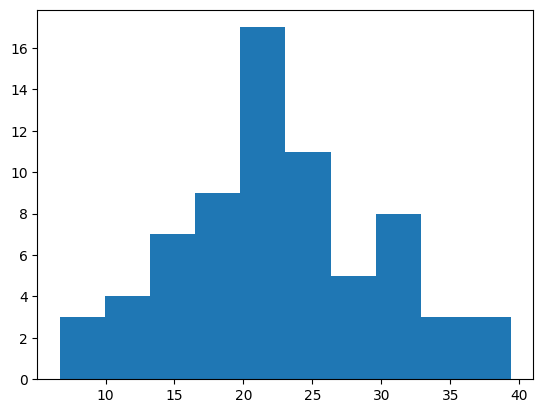

In [ ]:
#visualization of my data
plt.hist(data_lebronscore)

Based on the histogram, I'm assuming this is an approximately normal distribution so I will use that for my prior. It also helps that our data comes from real numbers and it varies symmetrically around a value.

I think I have a good idea of what the mean is, I'm assuming there's very little skew, but there is most definitely a solid chance of outliers.

I will use a half normal distribution for the prior standard deviation because it only contains positive, smaller values which prevents the model from having a huge variation.

In [ ]:
#N for normal
with pm.Model() as model_lebronscoreN:
    # I'm assuming the mean is 22 and the SD is 3
    μ = pm.Normal('μ', mu=22, sigma=3)

    #5 is used because of the textbook
    σ = pm.HalfNormal('σ', sigma=5)

    #Likelihood with two priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=data_lebronscore)
    idata_lebronscoreN = pm.sample()


Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

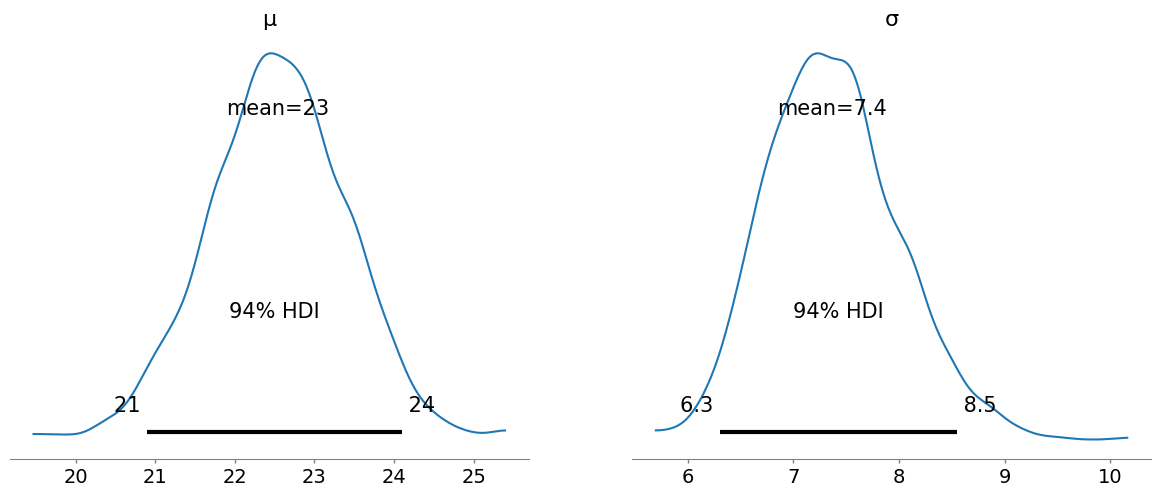

In [ ]:
az.plot_posterior(idata_lebronscoreN)

In [ ]:
pm.sample_posterior_predictive(idata_lebronscoreN, model=model_lebronscoreN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

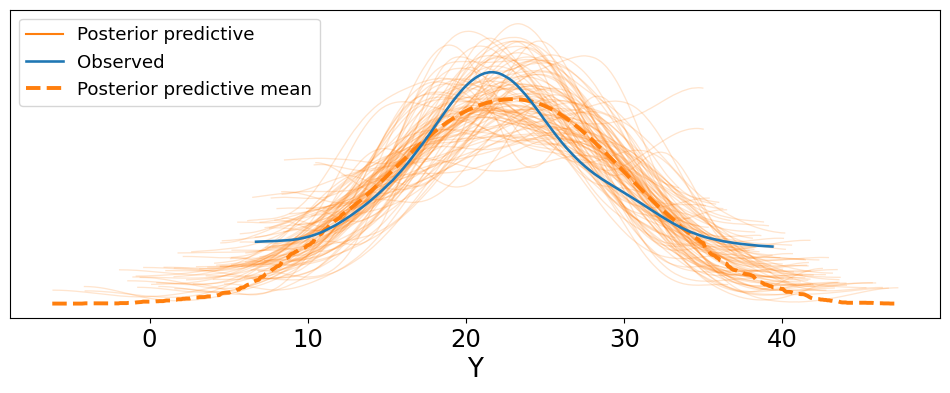

In [ ]:
#Plots the posterior predictive density overlaid with a smoothed version of the data
az.plot_ppc(idata_lebronscoreN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This was a pretty good start, with the correct shape, but the observed is still a little tighter and higher than the posterior predictive mean. I'll try to fix that with my next model.

In [ ]:
#T for StudentT
with pm.Model() as model_lebronscoreT:
    #same as before
    μ = pm.Normal('μ', mu=22, sigma=3)

    #also same as before
    σ = pm.HalfNormal('σ', sigma=5)

    #Likelihood with two priors
    Y = pm.StudentT('Y', nu = 1, mu = μ, sigma = σ, observed=data_lebronscore)
    idata_lebronscoreT = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

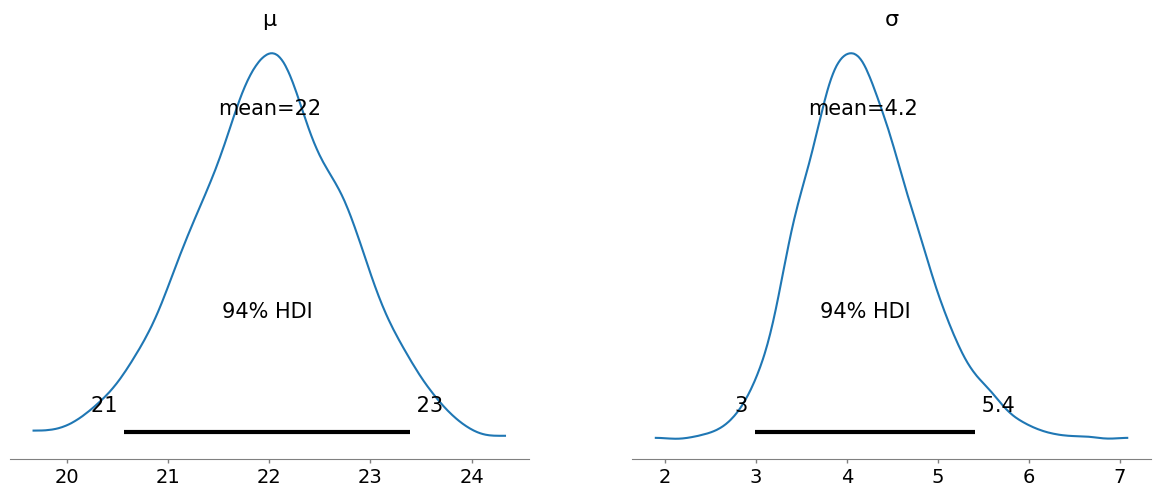

In [ ]:
az.plot_posterior(idata_lebronscoreT)

In [ ]:
pm.sample_posterior_predictive(idata_lebronscoreT, model=model_lebronscoreT, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 50.0)

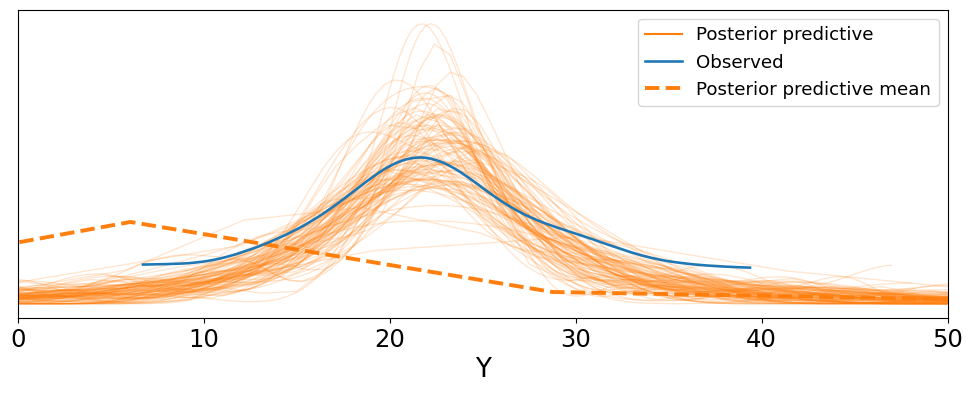

In [ ]:
ax = az.plot_ppc(idata_lebronscoreT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 50)

With the StudentT model, the Posterier predictive is extremely similar to our observed, so I think this will be the best model we can get due to the data not being skewed. The mean is way off but since the samples seem to align with our observed, I have faith in it. To confirm, I'll do one more plot with more samples.

(0.0, 50.0)

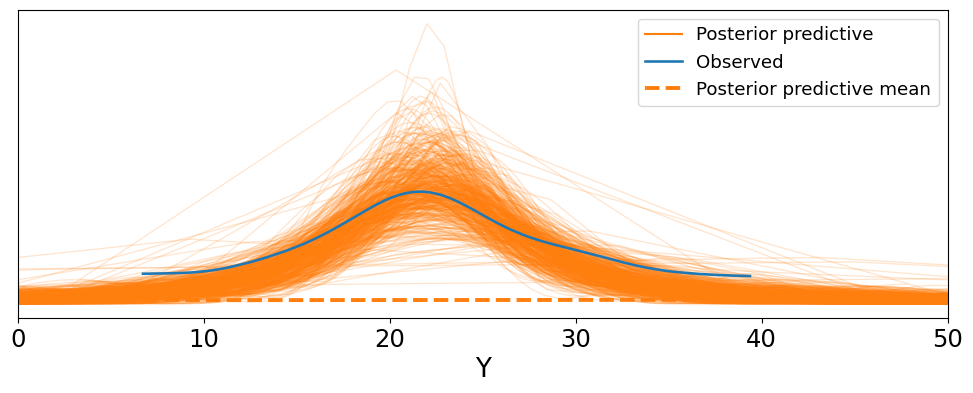

In [ ]:
ax = az.plot_ppc(idata_lebronscoreT, num_pp_samples=500, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 50)

More samples confirmed the StudentT model to be the best likelihood for this data, as you can see it is dark orange matching really closely with the observed. However, it is still not as good as it could be because my nu value is defined as a constant (1). To fix this I will make the nu value an exponential curve.

In [5]:
#FinalT for StudentT
with pm.Model() as model_lebronscoreFinalT:
    #same as before
    μ = pm.Normal('μ', mu=22, sigma=3)

    #also same as before
    σ = pm.HalfNormal('σ', sigma=5)

    #making nu not a constant
    v = pm.Exponential('ν', lam = 1/30)

    #nu is now different
    Y = pm.StudentT('Y', nu = v, mu = μ, sigma = σ, observed=data_lebronscore)
    idata_lebronscoreFinalT = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'ν'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

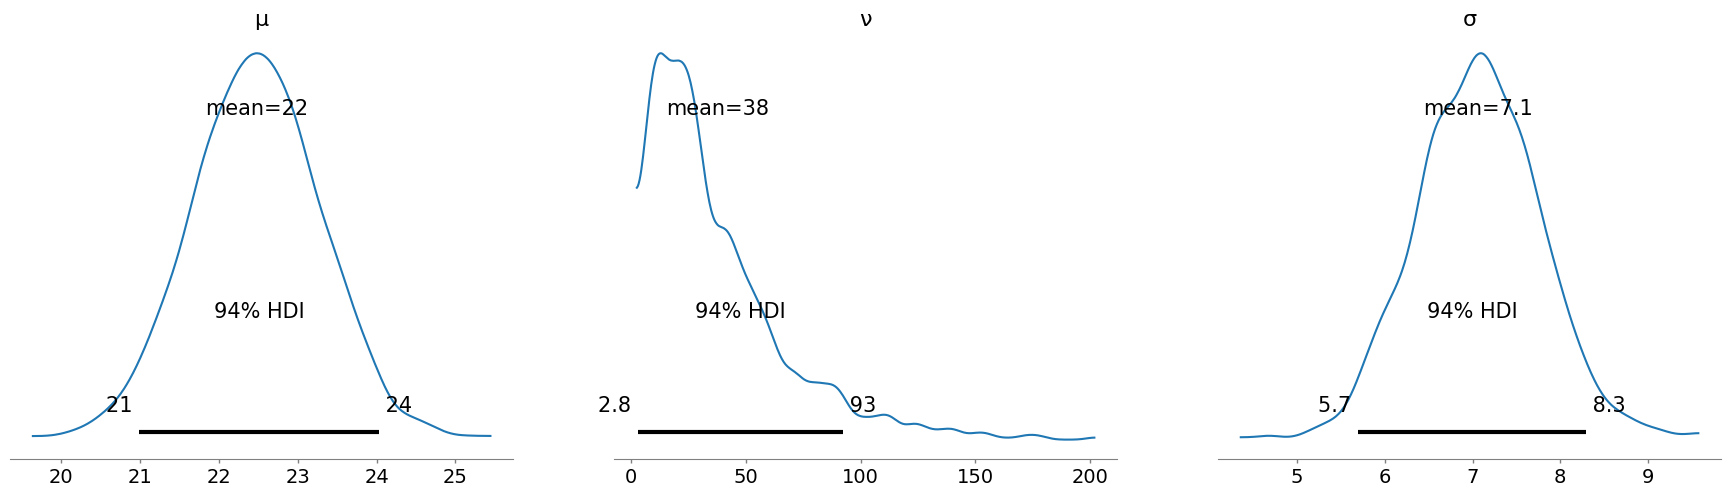

In [6]:
az.plot_posterior(idata_lebronscoreFinalT)

In [7]:
pm.sample_posterior_predictive(idata_lebronscoreFinalT, model=model_lebronscoreFinalT, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 50.0)

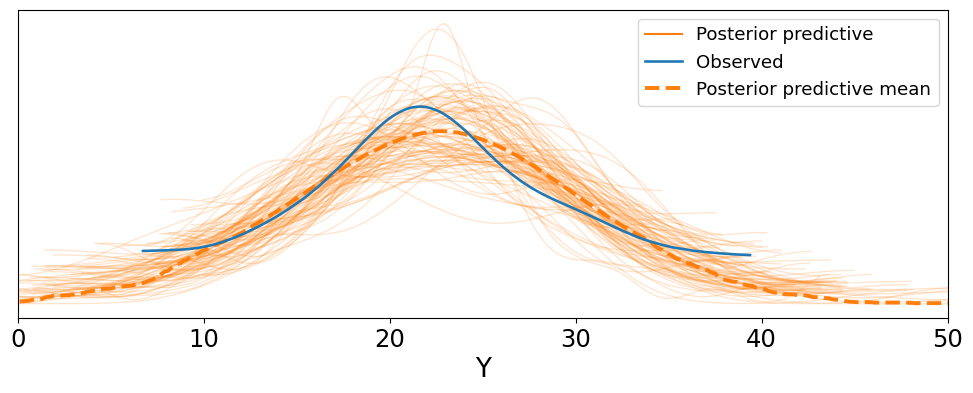

In [12]:
ax = az.plot_ppc(idata_lebronscoreFinalT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 50)

The posterior predictive mean is now fixed and my model looks extremely similar to the data.